In [1]:
import os
import json
import time
import random
import numpy as np
import pandas as pd
import pydicom
from PIL import Image
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [18]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="3"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
config = dict(
    saved_path="saved_models/efficientb4_cifar10.pt",
    best_saved_path = "saved/random_best.pt",
    lr=0.001, 
    EPOCHS = 3,
    BATCH_SIZE = 32,
    IMAGE_SIZE = 132,
    TRAIN_VALID_SPLIT = 0.2,
    device=device,
    SEED = 42,
    pin_memory=True,
    num_workers=2,
    USE_AMP = True,
    channels_last=False)

In [5]:
random.seed(config['SEED'])
# If you or any of the libraries you are using rely on NumPy, you can seed the global NumPy RNG 
np.random.seed(config['SEED'])
# Prevent RNG for CPU and GPU using torch
torch.manual_seed(config['SEED'])
torch.cuda.manual_seed(config['SEED'])
torch.backends.cudnn.benchmarks = True
torch.backends.cudnn.deterministic = True

torch.backends.cuda.matmul.allow_tf32 = True

# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
# Load data
train_data = torchvision.datasets.CIFAR10(root='../Images', train=True, download=True, transform=data_transforms['test'])
test_data = torchvision.datasets.CIFAR10(root='../Images', train=False, download=True, transform=data_transforms['test'])
valid_data = test_data

Files already downloaded and verified
Files already downloaded and verified


In [8]:
train_dl = torch.utils.data.DataLoader(train_data, batch_size=32,shuffle=True, num_workers = config['num_workers'],
                                          pin_memory = config['pin_memory'])


test_dl = torch.utils.data.DataLoader(test_data, batch_size=32,shuffle=True, num_workers = config['num_workers'],
                                          pin_memory = config['pin_memory'])
valid_dl = torch.utils.data.DataLoader(valid_data, batch_size=32,shuffle=True, num_workers = config['num_workers'],
                                          pin_memory = config['pin_memory'])

In [9]:
def train_model(model,criterion,optimizer,num_epochs=10):

    since = time.time()                                            
    batch_ct = 0
    example_ct = 0
    best_acc = 0.3
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        run_corrects = 0
        #Training
        model.train()
        for x,y in train_dl: #BS=32 ([BS,3,224,224], [BS,4])            
            if config['channels_last']:
                x = x.to(config['device'], memory_format=torch.channels_last) #CHW --> #HWC
            else:
                x = x.to(config['device'])
            y = y.to(config['device']) #CHW --> #HWC
            
            
            
            optimizer.zero_grad()
            #optimizer.zero_grad(set_to_none=True)
            ######################################################################
            
            train_logits = model(x) #Input = [BS,3,224,224] (Image) -- Model --> [BS,4] (Output Scores)
            
            _, train_preds = torch.max(train_logits, 1)
            train_loss = criterion(train_logits,y)
            train_loss = criterion(train_logits,y)
            run_corrects += torch.sum(train_preds == y.data)
            
            train_loss.backward() # Backpropagation this is where your W_gradient
            loss=train_loss

            optimizer.step() # W_new = W_old - LR * W_gradient 
            example_ct += len(x) 
            batch_ct += 1
            if ((batch_ct + 1) % 400) == 0:
                train_log(loss, example_ct, epoch)
            ########################################################################
        
        #validation
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        total = 0
        # Disable gradient calculation for validation or inference using torch.no_rad()
        with torch.no_grad():
            for x,y in valid_dl:
                if config['channels_last']:
                    x = x.to(config['device'], memory_format=torch.channels_last) #CHW --> #HWC
                else:
                    x = x.to(config['device'])
                y = y.to(config['device'])
                valid_logits = model(x)
                _, valid_preds = torch.max(valid_logits, 1)
                valid_loss = criterion(valid_logits,y)
                running_loss += valid_loss.item() * x.size(0)
                running_corrects += torch.sum(valid_preds == y.data)
                total += y.size(0)
            
        epoch_loss = running_loss / len(valid_data)
        epoch_acc = running_corrects.double() / len(valid_data)
        train_acc = run_corrects.double() / len(train_data)
        print("Train Accuracy",train_acc.cpu())
        print("Validation Loss is {}".format(epoch_loss))
        print("Validation Accuracy is {}\n".format(epoch_acc.cpu()))
        if epoch_acc.cpu()>best_acc:
            print('One of the best validation accuracy found.\n')
            #torch.save(model.state_dict(), config['best_saved_path'])
            best_acc = epoch_acc.cpu()

            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    torch.save(model.state_dict(), config['saved_path'])

    
def train_log(loss, example_ct, epoch):
    loss = float(loss)
    print(f"Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}")

In [11]:
efficientnet = models.efficientnet_b0(pretrained = True)
efficientnet.classifier[1] = nn.Linear(in_features = 1280, out_features = 10, bias = True)
model = efficientnet
criterion = nn.CrossEntropyLoss()
model = model.to(config['device'])
optimizer = optim.Adam(model.parameters(),lr=config['lr'])
model.load_state_dict(torch.load('saved_models/child.pt'))
#train_model(model,criterion,optimizer,num_epochs=8)

<All keys matched successfully>

In [12]:
def evaluation(model,test_dl):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    preds = []
    pred_labels = []
    labels = []

    with torch.no_grad():
                for x,y in test_dl:
                    x = x.to(config['device'])
                    y = y.to(config['device']) #CHW --> #HWC
                    valid_logits = model(x)
                    predict_prob = F.softmax(valid_logits)
                    _,predictions = predict_prob.max(1)
                    predictions = predictions.to('cpu')

                    _, valid_preds = torch.max(valid_logits, 1)
                    valid_loss = criterion(valid_logits,y)
                    running_loss += valid_loss.item() * x.size(0)
                    running_corrects += torch.sum(valid_preds == y.data)
                    total += y.size(0)
                    predict_prob = predict_prob.to('cpu')

                    pred_labels.extend(list(predictions.numpy()))
                    preds.extend(list(predict_prob.numpy()))
                    y = y.to('cpu')
                    labels.extend(list(y.numpy()))

    epoch_loss = running_loss / len(test_data)
    epoch_acc = running_corrects.double() / len(test_data)
    print("Test Loss is {}".format(epoch_loss))
    print("Test Accuracy is {}".format(epoch_acc.cpu()))
    return np.array(labels),np.array(pred_labels),np.array(preds)
    

labels, pred_labels,preds = evaluation(model, test_dl)
#print(metrics.precision_recall_fscore_support(np.array(labels), np.array(pred_labels)))
print('\nAUROC:')
print(metrics.roc_auc_score(np.array(labels), np.array(preds), multi_class='ovr'))
print(metrics.classification_report(labels,pred_labels))

Test Loss is 0.29729179959520696
Test Accuracy is 0.9142

AUROC:
0.9957011777777778
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1000
           1       0.97      0.95      0.96      1000
           2       0.94      0.84      0.89      1000
           3       0.82      0.86      0.84      1000
           4       0.92      0.90      0.91      1000
           5       0.85      0.89      0.87      1000
           6       0.89      0.95      0.92      1000
           7       0.98      0.90      0.94      1000
           8       0.92      0.97      0.95      1000
           9       0.95      0.94      0.95      1000

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000



In [20]:
def calculate_disparate_impact(model, dataloader):
    #device = next(model.parameters()).device
    model.eval()
    with torch.no_grad():
        class_counts = torch.zeros((10,))
        correct_counts = torch.zeros((10,))
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            for i in range(10):
                class_mask = labels == i
                class_counts[i] += torch.sum(class_mask)
                correct_counts[i] += torch.sum(preds[class_mask] == labels[class_mask])

        proportions = correct_counts / class_counts
        reference_proportion = torch.mean(proportions)
        max_proportion = torch.max(proportions)
        
        return reference_proportion / max_proportion

In [22]:
device = 'cpu'
model = model.to('cpu')
disparate_impact = calculate_disparate_impact(model, test_dl)
print(f"Disparate Impact: {disparate_impact:.4f}")

Disparate Impact: 0.9376


# Bias Observation

In [23]:
# Calculate the mean and standard deviation of the bias values of the layers
bias_mean = []
bias_std = []
for name, param in model.named_parameters():
    if 'bias' in name:
        bias_mean.append(param.data.mean().item())
        bias_std.append(param.data.std().item())
print(f'Bias mean: {np.mean(bias_mean)}')
print(f'Bias std: {np.mean(bias_std)}')

Bias mean: 0.10364648806415327
Bias std: 0.927578089418026


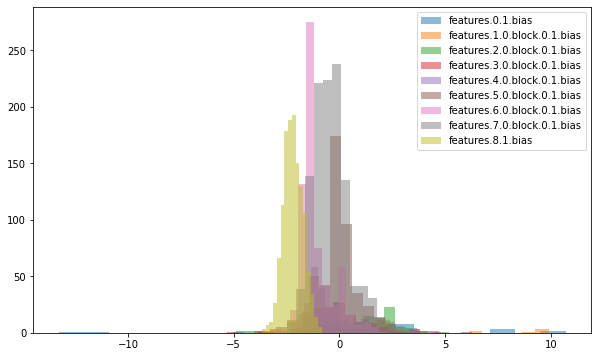

In [14]:
# Plotting a histogram of the bias values for some layers

model = model.to('cpu')
num = 0
plt.figure(figsize=(10,6))
for name, param in model.named_parameters():
    if 'bias' in name and f'features.{num}' in name:
        plt.hist(param.data.numpy(), bins=20, alpha=0.5, label=name)
        num+=1
        
plt.legend(loc='upper right')
plt.show()

# Cross Inductive Bias Distillation

Parent model: EfficientNet-B4

Child model: EfficientNet-B0

In [24]:
efficientnet = models.efficientnet_b4(pretrained = True)
efficientnet.classifier[1] = nn.Linear(in_features = 1792, out_features = 10, bias = True)
model = efficientnet
criterion = nn.CrossEntropyLoss()
model = model.to(config['device'])
optimizer = optim.Adam(model.parameters(),lr=config['lr'])

model.load_state_dict(torch.load('saved_models/parent_best.pt'))
#train_model(model,criterion,optimizer,num_epochs=8)

<All keys matched successfully>

In [26]:
labels, pred_labels,preds = evaluation(model, test_dl)
#print(metrics.precision_recall_fscore_support(np.array(labels), np.array(pred_labels)))
print('\nAUROC:')
print(metrics.roc_auc_score(np.array(labels), np.array(preds), multi_class='ovr'))
print(metrics.classification_report(labels,pred_labels))

Test Loss is 0.16448353337105365
Test Accuracy is 0.9524

AUROC:
0.998272772222222
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1000
           1       0.97      0.98      0.98      1000
           2       0.94      0.95      0.95      1000
           3       0.90      0.90      0.90      1000
           4       0.94      0.96      0.95      1000
           5       0.90      0.93      0.92      1000
           6       0.97      0.97      0.97      1000
           7       1.00      0.94      0.97      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.97      0.96      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



# Knowledge Distillation: Co-advice

In [24]:
teacher_model = model


efficientnet = models.efficientnet_b0(pretrained = True)
efficientnet.classifier[1] = nn.Linear(in_features = 1280, out_features = 10, bias = True)
model1 = efficientnet
model1 = model.to(config['device'])
student_model = model1

# Define the criterion (loss function) for knowledge distillation
class DistillationLoss(nn.Module):
    def __init__(self, T):
        super(DistillationLoss, self).__init__()
        self.T = T
        self.kl_div = nn.KLDivLoss(reduction='batchmean')
        
    def forward(self, outputs, labels, teacher_outputs):
        soft_labels = nn.functional.softmax(teacher_outputs/self.T, dim=1)
        log_soft_labels = nn.functional.log_softmax(outputs/self.T, dim=1)
        loss = self.kl_div(log_soft_labels, soft_labels) * (self.T * self.T)
        hard_loss = nn.functional.cross_entropy(outputs, labels)
        return loss + hard_loss
    
# Define the optimizer
optimizer = optim.Adam(student_model.parameters(), lr=0.001)

# Train the student model with knowledge distillation
def train_student_model(train_loader):
    distillation_loss = DistillationLoss(T=5) # T is the temperature parameter
    student_model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = student_model(inputs)
        teacher_outputs = teacher_model(inputs).detach()
        loss = distillation_loss(outputs, labels, teacher_outputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    print('Train Loss: {:.4f}'.format(train_loss))

# Evaluate the student model on the test set
def test_student_model(test_loader):
    student_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = student_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100 * correct / total
    print('Test Accuracy: {:.2f}%'.format(test_acc))


In [25]:
# Train the student model for 10 epochs using knowledge distillation
for epoch in range(3):
    print('Epoch: {}'.format(epoch+1))
    train_student_model(train_dl)
    test_student_model(test_dl)

Epoch: 1
Train Loss: 0.1217
Test Accuracy: 94.69%
Epoch: 2
Train Loss: 0.1186
Test Accuracy: 94.64%
Epoch: 3
Train Loss: 0.1063
Test Accuracy: 94.19%
Epoch: 4
Train Loss: 0.0997
Test Accuracy: 95.25%


In [26]:
labels, pred_labels,preds = evaluation(student_model, test_dl)
#print(metrics.precision_recall_fscore_support(np.array(labels), np.array(pred_labels)))
print('\nAUROC:')
print(metrics.roc_auc_score(np.array(labels), np.array(preds), multi_class='ovr'))
print(metrics.classification_report(labels,pred_labels))

Test Loss is 0.17310410901606083
Test Accuracy is 0.9525

AUROC:
0.9967054833333332
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1000
           1       0.95      0.99      0.97      1000
           2       0.91      0.97      0.94      1000
           3       0.93      0.87      0.90      1000
           4       0.96      0.94      0.95      1000
           5       0.90      0.93      0.91      1000
           6       0.97      0.98      0.98      1000
           7       0.98      0.96      0.97      1000
           8       0.97      0.97      0.97      1000
           9       0.98      0.95      0.97      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



In [28]:
device = 'cpu'
model = model.to('cpu')
disparate_impact = calculate_disparate_impact(model, test_dl)
print(f"Disparate Impact: {disparate_impact:.4f}")

Disparate Impact: 0.9669
